In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torchvision

In [25]:
# get alexnet
from alexnet import model as alexnet

print(alexnet)

Using cache found in /home/kevin/.cache/torch/hub/pytorch_vision_v0.9.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [23]:
# Run BigGAN

import torch
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.ERROR)

# Load pre-trained model tokenizer (vocabulary)
model = BigGAN.from_pretrained('biggan-deep-256').to("cuda")

In [5]:
# Prepare a input
truncation = 0.4
class_vector = one_hot_from_names(['coffee', 'coffee', 'mushroom'], batch_size=3)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=3)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
noise_vector.requires_grad_()
class_vector = torch.from_numpy(class_vector)

# If you have a GPU, put everything on cuda
noise_vector = noise_vector.to('cuda')
class_vector = class_vector.to('cuda')

In [6]:
import captum
import captum.optim as optimviz

In [32]:
# Normal image optimization with captum appears to work
target = alexnet.features[8]
channel = 0

image = optimviz.images.NaturalImage((224, 224)).to("cuda")
loss_fn = optimviz.loss.ChannelActivation(target, channel)
transforms = torch.nn.Sequential(
    torch.nn.ReflectionPad2d(4),
    optimviz.transforms.RandomSpatialJitter(8),
    optimviz.transforms.RandomScale(scale=(1, 0.975, 1.025, 0.95, 1.05)),
    torchvision.transforms.RandomRotation(degrees=(-5, 5)),
    optimviz.transforms.RandomSpatialJitter(2),
)
obj = optimviz.InputOptimization(
    alexnet, input_param=image, loss_function=loss_fn)
history = obj.optimize(optimviz.optimization.n_steps(128, True))

  0%|          | 0/128 [00:00<?, ? step/s]

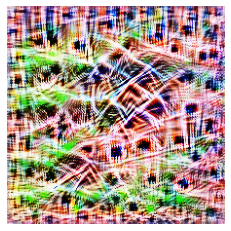

In [33]:
image().show()

In [8]:
# Generate an image
with torch.no_grad():
    output = model(noise_vector, class_vector, truncation)

# If you have a GPU put back on CPU
output = output.to('cpu')

print(output.shape)
image = torchvision.transforms.ToPILImage()(output[0])
display(image)

NameError: name 'noise_vector' is not defined